In [1]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(image_array):
    blurred_image = cv2.GaussianBlur(image_array, (5,5), 0)
    gray_image = cv2.cvtColor((blurred_image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

    return edges

In [3]:
def detect_keypoints_and_descriptors(image):
    sift = cv2.SIFT_create() 
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if keypoints is None or descriptors is None:
        return None, None, image
        
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return keypoints, descriptors

def match_features(desc1, desc2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches[:50]

In [4]:
VOC_CLASSES = [
    'chair',
    'diningtable',
    'person',
    'car',
    'motorbike',
    'bottle'
]

In [5]:
def is_in_voc_classes(img_path, anno_dir):
    img_file = os.path.basename(img_path)
    anno_file = img_file.replace('.jpg', '.xml')
    anno_path = os.path.join(anno_dir, anno_file)

    if not os.path.exists(anno_path):
        print(f"No annotation file found for {img_file}")
        return False

    tree = ET.parse(anno_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label in VOC_CLASSES:
            return True  
    return False

In [6]:
def prepare_features_and_labels(img_dir, anno_dir):
    features = []
    labels = []

    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(img_dir, img_file)
            if is_in_voc_classes(img_path, anno_dir):
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                preprocessed_image = preprocess_image(image_rgb)
                keypoints, descriptors = detect_keypoints_and_descriptors(preprocessed_image)

                if descriptors is not None:
                    feature_vector = np.mean(descriptors, axis=0)
                    anno_file = img_file.replace('.jpg', '.xml')
                    anno_path = os.path.join(anno_dir, anno_file)

                    tree = ET.parse(anno_path)
                    root = tree.getroot()

                    for obj in root.findall('object'):
                        label = obj.find('name').text
                        if label in VOC_CLASSES:
                            features.append(feature_vector)
                            labels.append(VOC_CLASSES.index(label))

    return np.array(features), np.array(labels)


In [7]:
import random

In [8]:
def train_classifier(X, y):
    knn = KNeighborsClassifier(n_neighbors=3) 
    knn.fit(X, y)
    return knn

def recognize_objects(img_dir, anno_dir, classifier):
    all_images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
    np.random.shuffle(all_images)
    processed_count = 0

    for img_path in all_images:
        if not has_voc_classes_annotation(img_path, anno_dir):
            print(f"Skipping {img_path} - No matching annotations found in VOC_CLASSES.")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.title(f"Processing Image: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()

        preprocessed_image = preprocess_image(image_rgb)
        keypoints, descriptors = detect_keypoints_and_descriptors(preprocessed_image)

        if descriptors is not None and len(descriptors) > 0:
            feature_vector = np.mean(descriptors, axis=0).reshape(1, -1)

            try:
                probabilities = classifier.predict_proba(feature_vector)
                top_indices = probabilities[0].argsort()[-3:][::-1]  

                print(f"Top predictions for '{os.path.basename(img_path)}':")
                for index in top_indices:
                    predicted_label = VOC_CLASSES[index]
                    score = probabilities[0][index]
                    print(f"  {predicted_label}: {score * 100:.2f}%")
            except Exception as e:
                print(f"Error during prediction: {e}")
        else:
            print(f"No descriptors detected for image: {os.path.basename(img_path)}")

        processed_count += 1
        if processed_count >= 10:
            print("Processed 10 images. Stopping.")
            break

In [9]:
def has_voc_classes_annotation(img_path, anno_dir):

    img_file = os.path.basename(img_path)
    anno_file = img_file.replace('.jpg', '.xml')
    anno_path = os.path.join(anno_dir, anno_file)

    if not os.path.exists(anno_path):
        return False

    tree = ET.parse(anno_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label in VOC_CLASSES:
            return True  
    return False

In [10]:
IMG_DIR = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
ANNO_DIR = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations'

In [11]:
features, labels = prepare_features_and_labels(IMG_DIR, ANNO_DIR)

In [12]:
classifier = train_classifier(features, labels)

Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/008847.jpg - No matching annotations found in VOC_CLASSES.


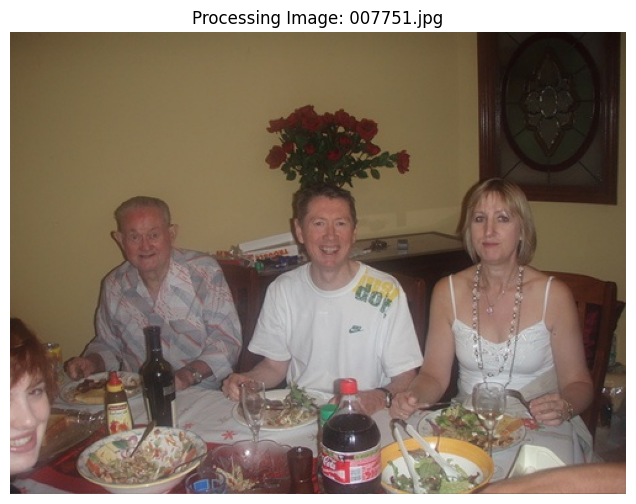

Top predictions for '007751.jpg':
  bottle: 100.00%
  motorbike: 0.00%
  car: 0.00%


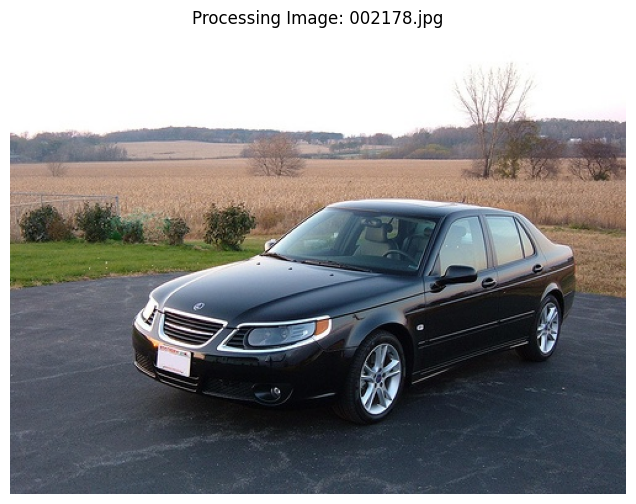

Top predictions for '002178.jpg':
  car: 66.67%
  person: 33.33%
  motorbike: 0.00%


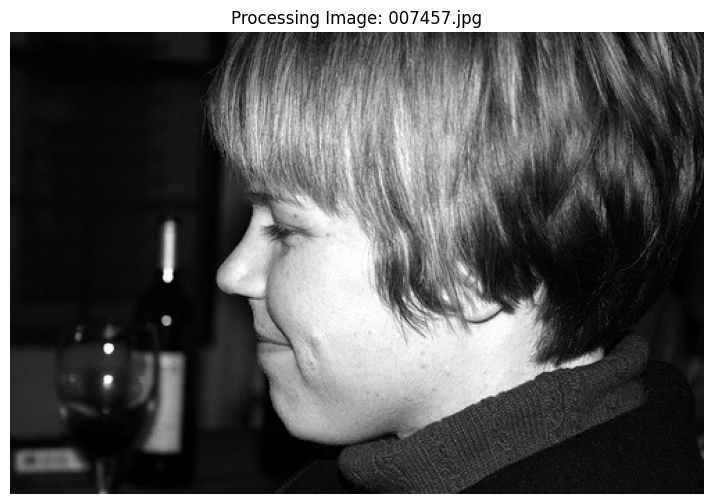

Top predictions for '007457.jpg':
  bottle: 33.33%
  car: 33.33%
  person: 33.33%


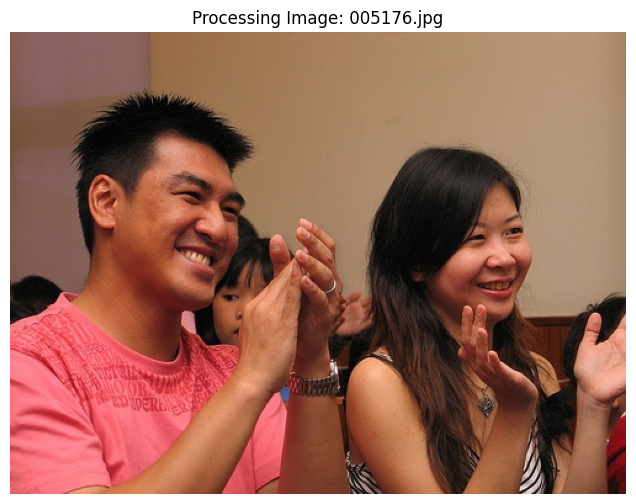

Top predictions for '005176.jpg':
  person: 100.00%
  bottle: 0.00%
  motorbike: 0.00%
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/003497.jpg - No matching annotations found in VOC_CLASSES.


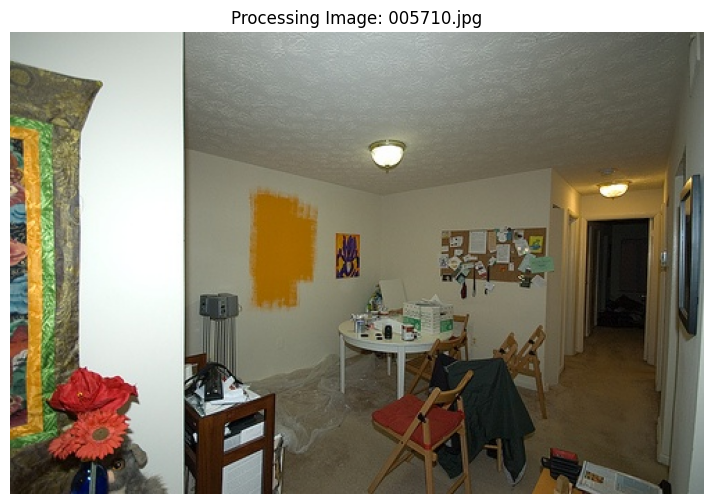

Top predictions for '005710.jpg':
  chair: 100.00%
  bottle: 0.00%
  motorbike: 0.00%


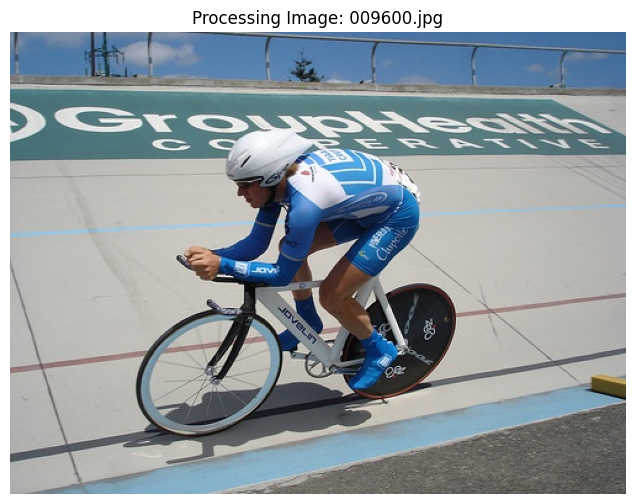

Top predictions for '009600.jpg':
  person: 100.00%
  bottle: 0.00%
  motorbike: 0.00%
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/003374.jpg - No matching annotations found in VOC_CLASSES.


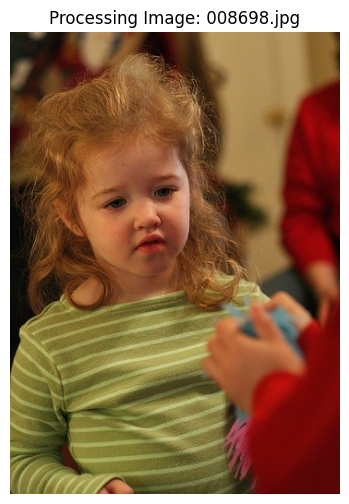

Top predictions for '008698.jpg':
  person: 66.67%
  chair: 33.33%
  motorbike: 0.00%
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005177.jpg - No matching annotations found in VOC_CLASSES.
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/004174.jpg - No matching annotations found in VOC_CLASSES.
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001898.jpg - No matching annotations found in VOC_CLASSES.
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002995.jpg - No matching annotations found in VOC_CLASSES.


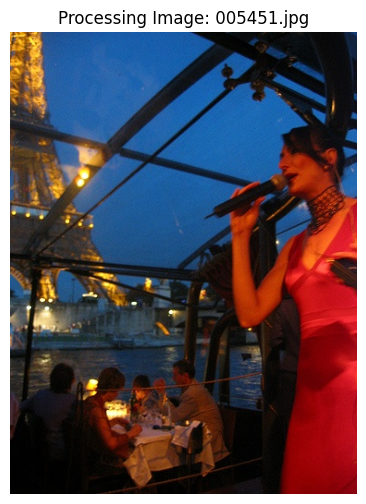

Top predictions for '005451.jpg':
  person: 100.00%
  bottle: 0.00%
  motorbike: 0.00%


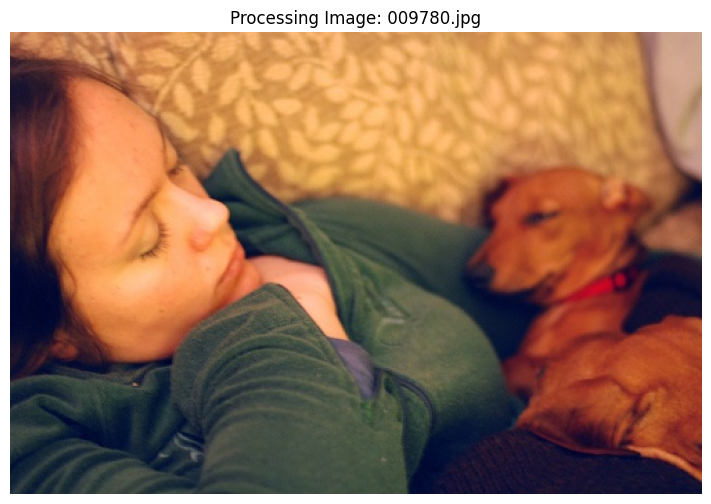

Top predictions for '009780.jpg':
  person: 100.00%
  bottle: 0.00%
  motorbike: 0.00%
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001840.jpg - No matching annotations found in VOC_CLASSES.
Skipping /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002732.jpg - No matching annotations found in VOC_CLASSES.


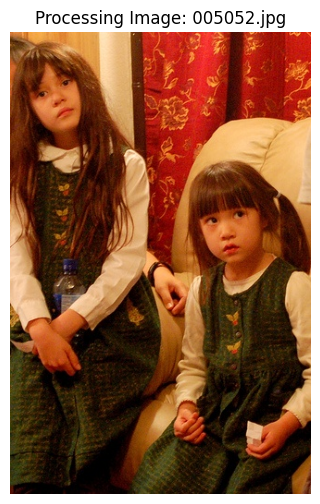

Top predictions for '005052.jpg':
  person: 66.67%
  bottle: 33.33%
  motorbike: 0.00%
Processed 10 images. Stopping.


In [13]:
recognize_objects(IMG_DIR, ANNO_DIR, classifier)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    return accuracy
accuracy = knn_classifier(features, labels)

Model Accuracy: 73.17%


In [25]:
import pickle

In [26]:
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(classifier, model_file)
print("KNN model saved successfully!")

KNN model saved successfully!


In [19]:
pip install gTTs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [22]:
from gtts import gTTS
from IPython.display import Audio

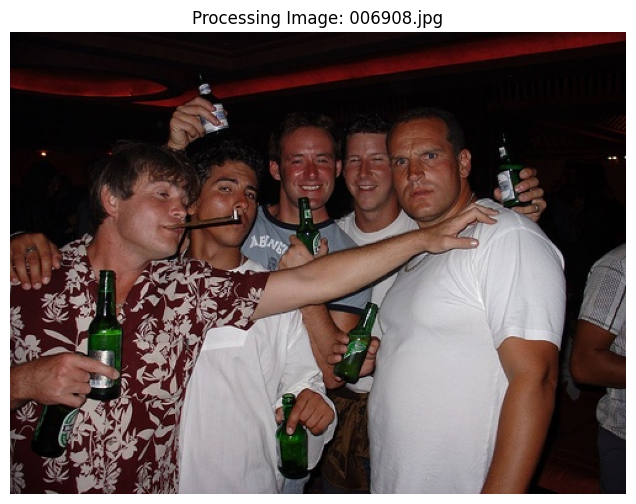

In [23]:
def recognize_top_3_labels_in_image(img_path, classifier, VOC_CLASSES):
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read image: {img_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"Processing Image: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

    preprocessed_image = preprocess_image(image_rgb)  
    keypoints, descriptors = detect_keypoints_and_descriptors(preprocessed_image)  

    if descriptors is not None and len(descriptors) > 0:
        feature_vector = np.mean(descriptors, axis=0).reshape(1, -1)

        feature_vector = feature_vector[:, :classifier.n_features_in_]  

        try:
            probabilities = classifier.predict_proba(feature_vector)

            sorted_indices = np.argsort(probabilities[0])[::-1] 
            top_predictions = [(VOC_CLASSES[i], probabilities[0][i]) for i in sorted_indices[:3]] 

            tts_output = ""
            for label, score in top_predictions:
                tts_output += f"Top prediction: {label} with {score * 100:.2f} percent. "

            tts = gTTS(tts_output, lang='en')
            audio_file_path = "outpujt.mp3"
            tts.save(audio_file_path)

            audio = Audio(audio_file_path, autoplay=True)
            return audio

        except Exception as e:
            print(f"Error during prediction: {e}")
            return None
    else:
        print(f"No descriptors detected for image: {os.path.basename(img_path)}")
        return None

img_path = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/006908.jpg' 
audio_variable = recognize_top_3_labels_in_image(img_path, classifier, VOC_CLASSES)

if audio_variable:
    audio_variable  


In [ ]:
recognize_top_3_labels_in_image(img_path, classifier, VOC_CLASSES)

In [15]:
cap = cv2.VideoCapture(0)  

if not cap.isOpened():
    print("Error: Unable to access the camera.")

Error: Unable to access the camera.


[ WARN:0@247.007] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@247.008] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
